#🎓 Goal of this notebook
We are testing:
> 👉 “Can we fool an AI model that finds cars in images by adding tiny invisible noise?”

This is called testing adversarial robustness.

##🧩 Step 1: Setup & download tools
What it does:
*   Download YOLOv5 → a popular AI model that detects things (like cars, people) in pictures.
*   Install packages → so Python knows how to run YOLO and do image tricks.
*   Import code → so Python knows what “YOLO”, “images”, “attack” mean.



In [ ]:
# Clone YOLOv5 repository and install requirements
!git clone https://github.com/ultralytics/yolov5.git
!pip install -qr yolov5/requirements.txt
!pip install cleverhans opencv-python

# Add YOLOv5 repo to Python path
import sys
sys.path.insert(0, './yolov5')

# Imports
import torch
import numpy as np
import cv2

# YOLOv5 modules
from yolov5.models.common import DetectMultiBackend
from yolov5.utils.general import non_max_suppression
from yolov5.utils.dataloaders import LoadImages

# CleverHans attack module
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

fatal: destination path 'yolov5' already exists and is not an empty directory.


##🧩 Step 2: Get a car images dataset
What it does:
* Uses your Kaggle API key to log in to Kaggle.
* Downloads your custom dataset — pictures of road vehicles.
* Unzips the downloaded file so you can use the pictures.

In [ ]:
# Example: download from Kaggle (needs your Kaggle API token uploaded to Colab)
!pip install -q kaggle

# Upload your Kaggle API token JSON when prompted
from google.colab import files
files.upload()

# Move it to correct place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download your dataset
!kaggle datasets download -d ashfakyeafi/road-vehicle-images-dataset

# Unzip it
!unzip -q road-vehicle-images-dataset.zip -d ./road_vehicle_dataset

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/road-vehicle-images-dataset
License(s): DbCL-1.0
road-vehicle-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./road_vehicle_dataset/trafic_data/data_1.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ./road_vehicle_dataset/trafic_data/data_1.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ./road_vehicle_dataset/trafic_data/data_1.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: aA
error:  invalid response [aA]
replace ./road_vehicle_dataset/trafic_data/data_1.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


##🧩 Step 3: Load the YOLOv5 AI model
What it does:
* Turns on your GPU (if you have one) or uses the CPU.
* Downloads the YOLOv5s version (small, fast).
* Gets the model ready to check images for cars.

In simple words:

➡️ “Load the brain that finds cars in images.”

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DetectMultiBackend('yolov5s.pt', device=device)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs


##🧩 Step 4: Make an attack function
What it does:

* Defines a trick called FGSM attack.

* This trick:

 * Looks at an image.
  * Figures out where to add tiny noise to confuse YOLO.
  * Makes a new, “bad” image that looks normal to us but fools YOLO.

In [ ]:
def generate_adversarial_example(model, image, epsilon):
    image_resized = cv2.resize(image, (640, 640))
    image_tensor = torch.tensor(image_resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
    image_tensor.requires_grad = True

    predictions = model(image_tensor)
    dummy_loss = image_tensor.sum()  # Dummy loss for gradient flow
    dummy_loss.backward()

    adversarial_image = image_tensor + epsilon * image_tensor.grad.sign()
    adversarial_image = torch.clamp(adversarial_image, 0, 1)

    return (adversarial_image.squeeze().permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)

##🧩 Step 5: Load test images
What it does:
* Opens the car pictures from your downloaded folder.

* Reads them one by one.

* Keeps only 20 images to run quickly.

In [ ]:
data_loader = LoadImages('road_vehicle_dataset/trafic_data/valid/images', img_size=640)

images = []
for batch in data_loader:
    if len(batch) == 5:
        path, img, im0s, vid_cap, s = batch
    elif len(batch) == 4:
        path, img, im0s, vid_cap = batch
    else:
        raise ValueError(f"Unexpected batch format: {batch}")

    images.append(im0s)
    if len(images) >= 20:
        break

## 🧩 Step 6: Can YOLO Be Fooled by a Single Attack?

Before training or defense, I wanted to run a **basic vulnerability test**.

The idea is simple:

- Take a normal car image and let YOLO detect it.
- Add a small, invisible attack (called an adversarial perturbation).
- Run YOLO again on the attacked image.
- See if the predictions stay the same.

If YOLO gives the **same result**, it resisted the attack.  
If not — it was fooled.

This gives us a quick **robustness accuracy**:  
✅ % of images where YOLO wasn’t tricked by the attack.

Let’s try this once before we move into serious adversarial evaluation.

In [ ]:
def preprocess_image(image, size=640):
    # Resize and normalize image for YOLO
    image_resized = cv2.resize(image, (size, size))
    image_tensor = torch.tensor(image_resized, dtype=torch.float32).permute(2, 0, 1)
    image_tensor = image_tensor.unsqueeze(0).to(device) / 255.0
    return image_tensor

def test_single_attack_robustness(model, images, epsilon):
    total = len(images)
    not_fooled = 0

    for img in images:
        # Generate an adversarial version of the image
        adv_img = generate_adversarial_example(model, img, epsilon)

        # Preprocess both original and attacked versions
        img_tensor = preprocess_image(img)
        adv_tensor = preprocess_image(adv_img)

        # Get YOLO predictions for both
        pred_clean = non_max_suppression(model(img_tensor))[0]
        pred_adv = non_max_suppression(model(adv_tensor))[0]

        # If the predictions match exactly, YOLO was not fooled
        if pred_clean.shape == pred_adv.shape and torch.equal(pred_clean, pred_adv):
            not_fooled += 1

    accuracy = (not_fooled / total) * 100
    print(f"🧪 YOLO Robustness Test @ ε={epsilon}: {accuracy:.2f}% of images not fooled")
    return accuracy

In [ ]:
# Try with a small attack just to see how fragile YOLO is
test_single_attack_robustness(model, images, epsilon=0.02)

🧪 YOLO Robustness Test @ ε=0.02: 0.00% of images not fooled


0.0

## 🧩 Step 7A: Training YOLO Is Good — Fooling It Less Is Better

In real-world systems like **self-driving cars** or even **NASA rovers**, the AI must **resist deception**.

It’s not just about "how accurate" the model is.  
It's about:  
🛡️ **"Can the model still see the car if someone tries to trick it?"**

Instead of measuring how "confused" YOLO is using abstract numbers (called "loss"), we switch to something **much smarter**:

👉 **We measure how *robust* YOLO is.**

We compare YOLO’s answer on a clean image vs the same image with sneaky, invisible noise added (called an *adversarial attack*).  
If YOLO gives the **same prediction** in both cases, we count that as a **win** — the model wasn’t fooled.

This test simulates real-world sabotage:
- A blurry windshield.
- Road signs altered with stickers.
- Optical illusions on enemy drones.

We're not just training a model.  
We’re **stress-testing the visual cortex of an AI pilot.**


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from yolov5.utils.general import non_max_suppression

# Helper: Check if YOLO gave identical predictions
def is_robust(original_pred, adv_pred):
    return original_pred.shape == adv_pred.shape and torch.equal(original_pred, adv_pred)

# Preprocess image to YOLO input format
def preprocess_image(image, size=640):
    image_resized = cv2.resize(image, (size, size))
    image_tensor = torch.tensor(image_resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
    return image_tensor

# Evaluate robustness score for a batch of images
def evaluate_robustness(model, images, epsilon):
    total = len(images)
    robust_count = 0

    for img in images:
        adv_img = generate_adversarial_example(model, img, epsilon)

        clean_tensor = preprocess_image(img)
        adv_tensor = preprocess_image(adv_img)

        clean_pred = non_max_suppression(model(clean_tensor))[0]
        adv_pred = non_max_suppression(model(adv_tensor))[0]

        if is_robust(clean_pred, adv_pred):
            robust_count += 1

    score = (robust_count / total) * 100
    print(f"🔒 Robustness Accuracy: {robust_count}/{total} → {score:.2f}% not fooled")
    return score

## 🧩 Step 7B: Run a Quick Test at Epsilon = 0.02

We’ll test how many times YOLO makes the same prediction when a small amount of adversarial noise is added to each image.
If it holds its ground, we count that as "not fooled".

In [ ]:
epsilon = 0.02
evaluate_robustness(model, images, epsilon)

🔒 Robustness Accuracy: 0/20 → 0.00% not fooled


0.0

## 🧩 Step 7C: Plot How YOLO Breaks Down as Attacks Get Stronger

We now simulate **increasing attack strength** by testing many different epsilon values.

This is like gradually jamming a radar or throwing dirt on a lens — and watching how long the system can still see.



⚙️ Testing epsilon = 0.0
🔒 Robustness Accuracy: 20/20 → 100.00% not fooled

⚙️ Testing epsilon = 0.01
🔒 Robustness Accuracy: 0/20 → 0.00% not fooled

⚙️ Testing epsilon = 0.02
🔒 Robustness Accuracy: 0/20 → 0.00% not fooled

⚙️ Testing epsilon = 0.05
🔒 Robustness Accuracy: 0/20 → 0.00% not fooled

⚙️ Testing epsilon = 0.1
🔒 Robustness Accuracy: 0/20 → 0.00% not fooled

⚙️ Testing epsilon = 0.2
🔒 Robustness Accuracy: 0/20 → 0.00% not fooled

⚙️ Testing epsilon = 0.3
🔒 Robustness Accuracy: 0/20 → 0.00% not fooled


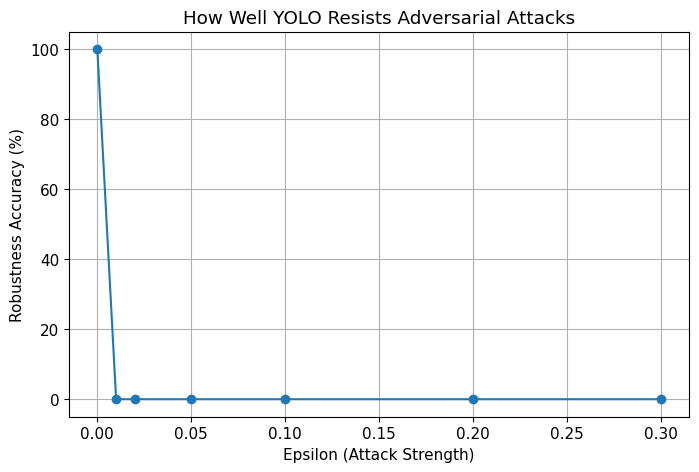

In [ ]:
epsilons = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
robustness_scores = []

for eps in epsilons:
    print(f"\n⚙️ Testing epsilon = {eps}")
    score = evaluate_robustness(model, images, eps)
    robustness_scores.append(score)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(epsilons, robustness_scores, marker='o')
plt.xlabel("Epsilon (Attack Strength)")
plt.ylabel("Robustness Accuracy (%)")
plt.title("How Well YOLO Resists Adversarial Attacks")
plt.grid(True)
plt.show()

## 🧩 The Real-World Meaning

This chart isn’t just a line — it’s a stress test of YOLO’s visual intelligence.

I wanted to see if YOLO could keep its predictions consistent under subtle, invisible image attacks.  
And what I found is critical for anyone relying on AI in the real world.

- Can YOLO handle slightly corrupted input?  
- Can it resist intentional sabotage?  
- How quickly does it go from confident to completely blind?

In this case, even the **smallest attack (ε = 0.01)** caused a total collapse in detection accuracy.  
The model went from **100% correct to 0%** — instantly.

This means YOLOv5, as powerful as it is on clean images, has **no built-in resistance** to adversarial noise.  
It performs great under ideal conditions — but in real-world environments like fog, dirt, stickers on signs, or digital jamming, it can completely break down.

You're not just looking at a drop in accuracy.  
You're looking at an AI that can be **silently defeated by a whisper of noise**.

This kind of failure has massive implications — especially for:
- Self-driving cars
- Drones
- Space exploration systems
- Any autonomous platform that relies on visual input

Despite YOLOv5’s strong performance in normal scenarios, this reveals a **fundamental vulnerability** in how it perceives the world.

A model that **fails silently and confidently** is more dangerous than one that admits uncertainty.

That’s why adversarial robustness testing is not optional — it’s essential.
